<a href="https://colab.research.google.com/github/sc-nun216/5m-data-3.8-computer-vision/blob/main/assignment_3_8_alt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment

## Instructions

In this assignment, you will apply the computer vision concepts covered in the lesson to perform image classification using the Fashion MNIST dataset. The Fashion MNIST dataset consists of 60,000 28x28 grayscale images of 10 fashion categories.

### Task: Build an Image Classifier

1. Use the provided starter code to load and explore the Fashion MNIST dataset
2. Preprocess the images using appropriate techniques (e.g., normalization, data augmentation)
3. Build a CNN model to classify the images into one of the 10 classes
4. Train your model and evaluate its performance
5. Experiment with at least one technique to improve model performance (e.g., batch normalization, different pooling strategies, additional convolutional layers)
6. Visualize and analyze your result

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define transformations
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Classes in Fashion MNIST
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape} (C, H, W)")

Training samples: 60000, Testing samples: 10000
Image shape: torch.Size([1, 28, 28]) (C, H, W)


In [43]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. Using GPU.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU.')

CUDA is available. Using GPU.


In [44]:
# Define the CNN model
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Max Pooling Layer 1
        self.pool1 = nn.MaxPool2d(2, 2)


        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Max Pooling Layer 2
        self.pool2 = nn.MaxPool2d(2, 2)


        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Max Pooling Layer 3
        self.pool3 = nn.MaxPool2d(2, 2)


        # Calculate the size of the flattened layer
        # The input image size is 28x28
        # After conv1, pool1: (28/2) = 14x14
        # After conv2, pool2: (14/2) = 7x7
        # After conv3, pool3: (7/2) = 3x3 (integer division) - need to verify output size

        # Correct calculation for output size after 3 pooling layers with kernel 2 and stride 2:
        # ((input_size - kernel_size)/stride) + 1
        # Layer 1: ((28 - 2)/2) + 1 = 13 + 1 = 14. Output size after pool1 is 14x14.
        # Layer 2: ((14 - 2)/2) + 1 = 6 + 1 = 7. Output size after pool2 is 7x7.
        # Layer 3: ((7 - 2)/2) + 1 = 2 + 1 = 3. Output size after pool3 is 3x3.

        # Fully Connected Layer 1
        self.fc1 = nn.Linear(128 * 3 * 3, 128) # Adjust the input size based on the output of the last pooling layer
        # Dropout Layer for FC1
        self.dropout_fc = nn.Dropout(0.5)
        # Fully Connected Layer 2 (Output Layer)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply Conv1, BN1, ReLU, Pool1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # Apply Conv2, BN2, ReLU, Pool2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # Apply Conv3, BN3, ReLU, Pool3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)
        # Apply FC1, ReLU, and Dropout
        x = self.dropout_fc(F.relu(self.fc1(x)))
        # Apply FC2 (Output Layer)
        output = F.log_softmax(self.fc2(x), dim=1)
        return output

model = FashionCNN().to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (dropout_fc): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [45]:
# Training loop
def train_model(model, criterion, optimizer, train_loader, epochs=10):
    train_losses = []

    for epoch in range(epochs):
        model.train() # Set the model to training mode
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

    print('Finished Training')
    return train_losses


# Evaluation function
def evaluate_model(model, test_loader, classes):
    model.eval()
    correct = 0
    total = 0
    # These lists are crucial for class-wise comparison
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calculate class-wise accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Calculate overall accuracy
    overall_accuracy = 100 * correct / total

    # Print summary (optional, but good for immediate feedback)
    print(f'\nAccuracy of the network on the {total} test images: {overall_accuracy:.2f} %')

    # --- MODIFICATION IS HERE ---
    # Return the three necessary components:
    # 1. overall accuracy (as a percentage)
    # 2. class_correct list
    # 3. class_total list
    return overall_accuracy, class_correct, class_total

In [46]:
EPOCHS = 15
history = train_model(model, criterion, optimizer, train_loader, epochs=EPOCHS)

# Run evaluation
test_accuracy, original_class_correct, original_class_total = evaluate_model(model, test_loader, classes)

Epoch 1/15, Loss: 0.5324
Epoch 2/15, Loss: 0.3742
Epoch 3/15, Loss: 0.3281
Epoch 4/15, Loss: 0.3023
Epoch 5/15, Loss: 0.2824
Epoch 6/15, Loss: 0.2662
Epoch 7/15, Loss: 0.2594
Epoch 8/15, Loss: 0.2422
Epoch 9/15, Loss: 0.2342
Epoch 10/15, Loss: 0.2267
Epoch 11/15, Loss: 0.2186
Epoch 12/15, Loss: 0.2098
Epoch 13/15, Loss: 0.2064
Epoch 14/15, Loss: 0.1999
Epoch 15/15, Loss: 0.1941
Finished Training

Accuracy of the network on the 10000 test images: 90.83 %


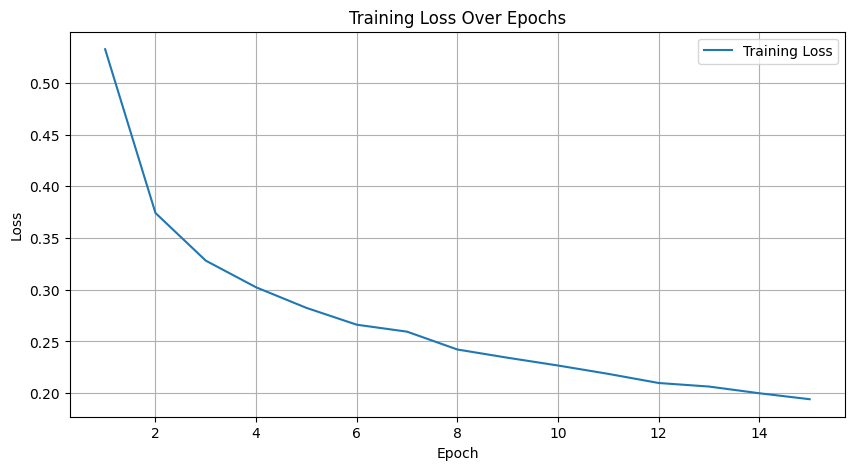


Final Test Accuracy after 15 epochs: 90.83%


In [47]:
def visualize_results(history, accuracy, epochs):
    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), history, label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Final Accuracy
    print(f"\nFinal Test Accuracy after {epochs} epochs: {accuracy:.2f}%")

visualize_results(history, test_accuracy, EPOCHS)

In [48]:
# helper functions - get prediction, confusion matrix, visualize prediction
def get_predictions(model, loader):
    """Gathers all true labels and predicted labels from the test set."""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(y_true, y_pred, class_names, filename='fashion_mnist_confusion_matrix.png'):
    """Calculates and plots the confusion matrix using scikit-learn."""
    cm = confusion_matrix(y_true, y_pred)
    # Normalize the matrix to show percentages, which is often easier to interpret
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Use 'gist_heat_r' or a similar colormap for better visibility
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45, values_format='.2f')
    plt.title('Normalized Confusion Matrix for Fashion MNIST')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    # If running in a script, you would save it: plt.savefig(filename)

def visualize_predictions(model, loader, class_names, device, num_samples=10):
    """Plots a batch of test images with their true and predicted labels."""
    model.eval()
    images, labels = next(iter(loader))
    images = images[:num_samples]
    labels = labels[:num_samples]

    with torch.no_grad():
        images_on_device = images.to(device)
        outputs = model(images_on_device)
        _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    for i in range(num_samples):
        # Denormalize image for display: x * std + mean
        # Images are 1-channel, so we select the first channel [0]
        img = images[i][0] * 0.5 + 0.5

        true_label = class_names[labels[i].item()]
        predicted_label = class_names[preds[i].item()]

        color = 'green' if true_label == predicted_label else 'red'

        axes[i].imshow(img.cpu().numpy(), cmap='gray')
        axes[i].set_title(f'True: {true_label}\nPred: {predicted_label}', color=color, fontsize=9)
        axes[i].axis('off')

    plt.suptitle("Sample Model Predictions (Correct: Green, Incorrect: Red)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # If running in a script, you would save it: plt.savefig(filename)



Generating Confusion Matrix...


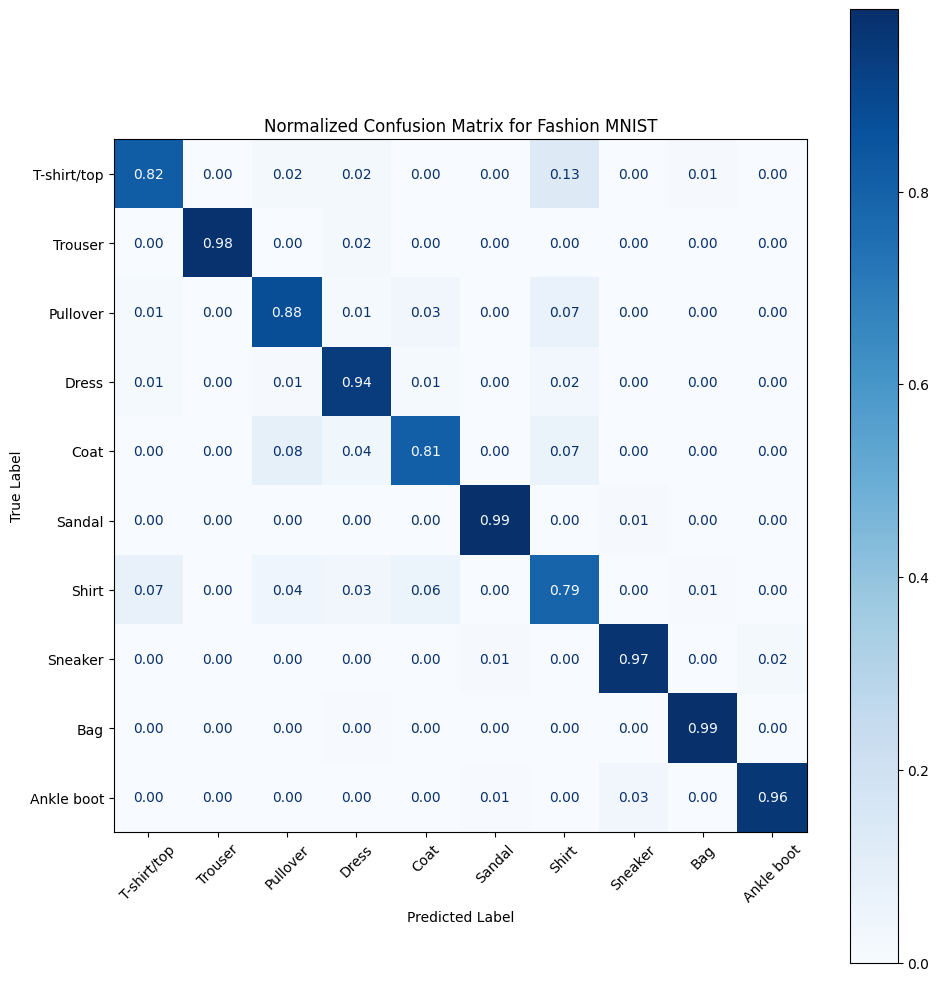


Generating Sample Predictions Visualization...


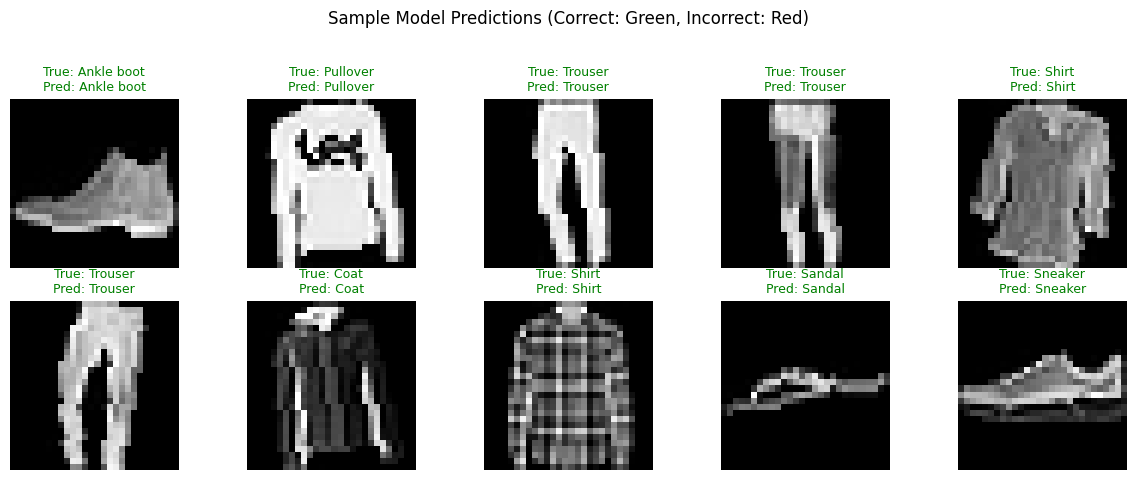

In [49]:
# Get Predictions on the Test Set
true_labels, predicted_labels = get_predictions(model, test_loader)

# Plot Confusion Matrix
print("\nGenerating Confusion Matrix...")
plot_confusion_matrix(true_labels, predicted_labels, classes)

# Visualize Sample Predictions
print("\nGenerating Sample Predictions Visualization...")
visualize_predictions(model, test_loader, classes, device, num_samples=10)

In [50]:
# Define an improved CNN model architecture
class ImprovedFashionCNN(nn.Module):
    def __init__(self):
        super(ImprovedFashionCNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Max Pooling Layer 1
        self.pool1 = nn.MaxPool2d(2, 2)


        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Max Pooling Layer 2
        self.pool2 = nn.MaxPool2d(2, 2)


        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Max Pooling Layer 3
        self.pool3 = nn.MaxPool2d(2, 2)

        # Convolutional Layer 4 (Added Layer)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        # Max Pooling Layer 4
        self.pool4 = nn.MaxPool2d(2, 2)


        # Calculate the size of the flattened layer
        # Correct calculation for output size after 4 pooling layers with kernel 2 and stride 2:
        # Layer 1: ((28 - 2)/2) + 1 = 14. Output size after pool1 is 14x14.
        # Layer 2: ((14 - 2)/2) + 1 = 7. Output size after pool2 is 7x7.
        # Layer 3: ((7 - 2)/2) + 1 = 3. Output size after pool3 is 3x3.
        # Layer 4: ((3 - 2)/2) + 1 = 1. Output size after pool4 is 1x1.


        # Fully Connected Layer 1
        self.fc1 = nn.Linear(256 * 1 * 1, 128) # Adjust the input size based on the output of the last pooling layer
        # Dropout Layer for FC1
        self.dropout_fc = nn.Dropout(0.5)
        # Fully Connected Layer 2 (Output Layer)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply Conv1, BN1, ReLU, Pool1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # Apply Conv2, BN2, ReLU, Pool2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # Apply Conv3, BN3, ReLU, Pool3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        # Apply Conv4, BN4, ReLU, Pool4
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)
        # Apply FC1, ReLU, and Dropout
        x = self.dropout_fc(F.relu(self.fc1(x)))
        # Apply FC2 (Output Layer)
        output = F.log_softmax(self.fc2(x), dim=1)
        return output

# Initialize the improved model and move it to the appropriate device
improved_model = ImprovedFashionCNN().to(device)
print(improved_model)

# Define loss function and optimizer for the improved model
improved_criterion = nn.CrossEntropyLoss()
improved_optimizer = optim.Adam(improved_model.parameters(), lr=0.001)

ImprovedFashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=

In [51]:
# Train improved
EPOCHS = 15
improved_train_losses = train_model(improved_model, improved_criterion, improved_optimizer, train_loader, epochs=EPOCHS)

# Run evaluation on improved model
improved_accuracy, improved_class_correct, improved_class_total = evaluate_model(improved_model, test_loader, classes)

Epoch 1/15, Loss: 0.4652
Epoch 2/15, Loss: 0.3247
Epoch 3/15, Loss: 0.2828
Epoch 4/15, Loss: 0.2581
Epoch 5/15, Loss: 0.2368
Epoch 6/15, Loss: 0.2231
Epoch 7/15, Loss: 0.2079
Epoch 8/15, Loss: 0.1969
Epoch 9/15, Loss: 0.1858
Epoch 10/15, Loss: 0.1776
Epoch 11/15, Loss: 0.1697
Epoch 12/15, Loss: 0.1645
Epoch 13/15, Loss: 0.1565
Epoch 14/15, Loss: 0.1464
Epoch 15/15, Loss: 0.1446
Finished Training

Accuracy of the network on the 10000 test images: 91.69 %


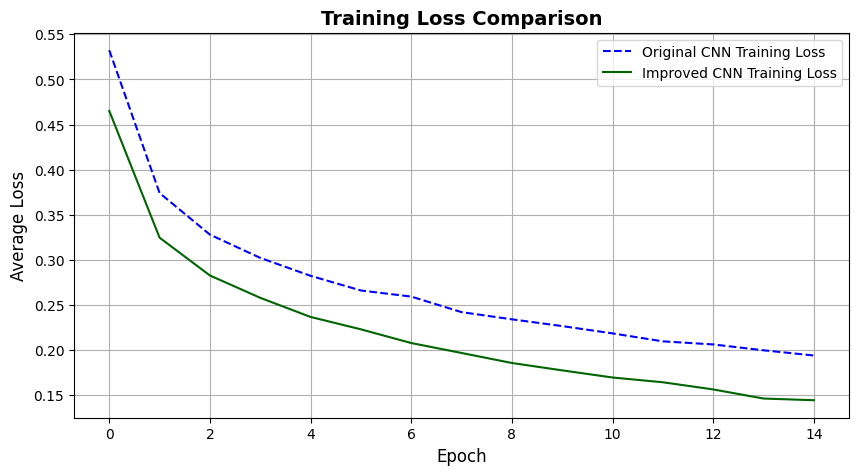

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(history, label='Original CNN Training Loss', linestyle='--', color='blue')
plt.plot(improved_train_losses, label='Improved CNN Training Loss', color='darkgreen')

plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


Generating Confusion Matrix for Improved Model...


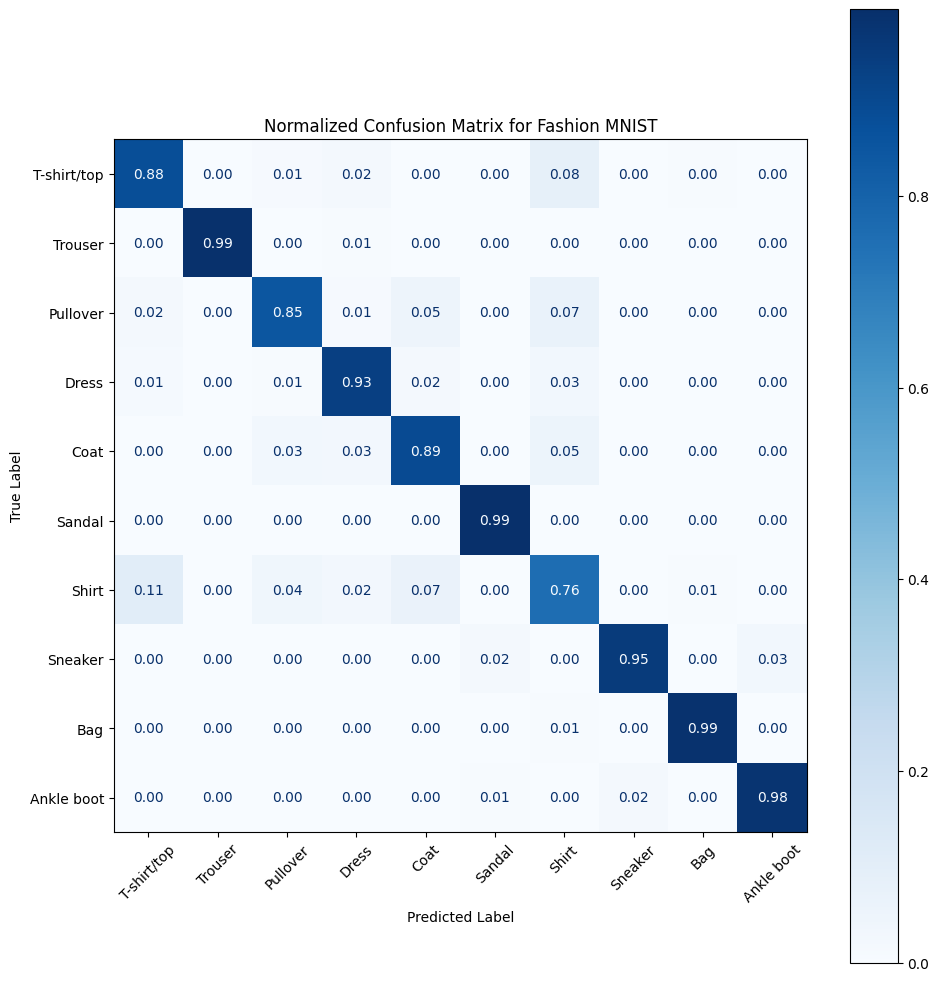


Summary of Results:
Original CNN Accuracy: 90.83%
Improved CNN Accuracy: 91.69%
Improvement: +0.86 percentage points

Class-wise Improvement (Percentage Points):
  T-shirt/top    : +7.10 pts
  Trouser        : +0.20 pts
  Pullover       : -2.70 pts
  Dress          : -0.80 pts
  Coat           : +8.30 pts
  Sandal         : +1.20 pts
  Shirt          : -1.90 pts
  Sneaker        : -3.30 pts
  Bag            : -0.80 pts
  Ankle boot     : +1.30 pts

Generating Confusion Matrix for Improved Model...


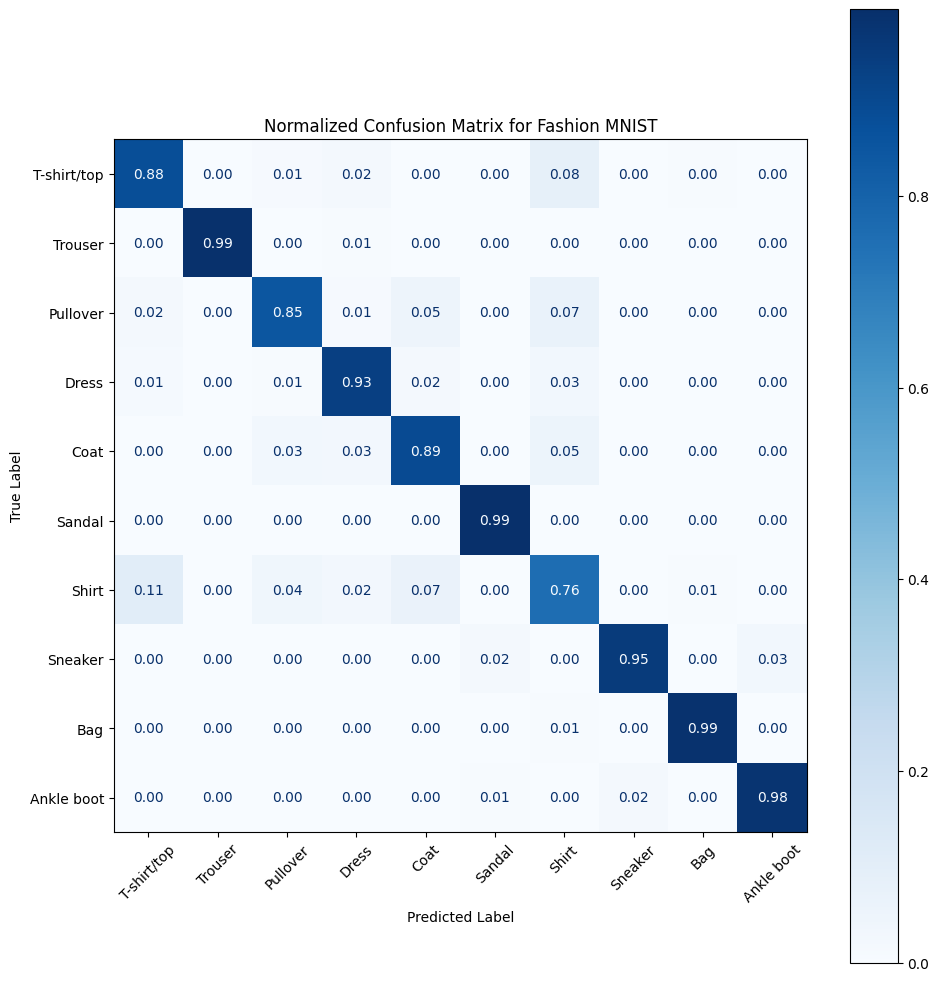


Generating Sample Predictions Visualization for Improved Model...


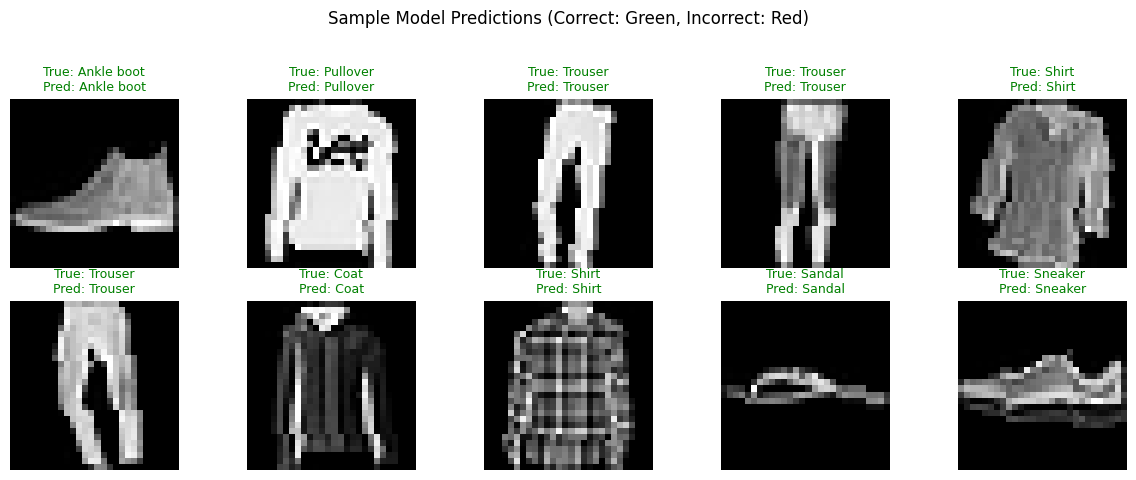

In [53]:
# Get Predictions on the Test Set for the Improved Model
improved_true_labels, improved_predicted_labels = get_predictions(improved_model, test_loader)

# Plot confusion matrix for improved model
print("\nGenerating Confusion Matrix for Improved Model...")
plot_confusion_matrix(improved_true_labels, improved_predicted_labels, classes)

# --- Summary of the assignment results ---
print("\n" + "="*30)
print("Summary of Results:")
print(f"Original CNN Accuracy: {test_accuracy:.2f}%")
print(f"Improved CNN Accuracy: {improved_accuracy:.2f}%")
# Calculate the improvement
improvement_value = improved_accuracy - test_accuracy
print(f"Improvement: {improvement_value:+.2f} percentage points")
print("="*30)

# --- Class-wise improvement ---
print("\nClass-wise Improvement (Percentage Points):")

for i in range(len(classes)):
    # Calculate accuracy for the Original Model (Handling potential division by zero)
    orig_acc = (original_class_correct[i] / original_class_total[i]) * 100 if original_class_total[i] > 0 else 0

    # Calculate accuracy for the Improved Model
    imp_acc = (improved_class_correct[i] / improved_class_total[i]) * 100 if improved_class_total[i] > 0 else 0

    # Print the difference (using + to show positive improvement clearly)
    print(f"  {classes[i]:15s}: {imp_acc - orig_acc:+.2f} pts")

# Plot confusion matrix for improved model
print("\nGenerating Confusion Matrix for Improved Model...")
plot_confusion_matrix(
    y_true=improved_true_labels,
    y_pred=improved_predicted_labels,
    class_names=classes
)


# Visualize Sample Predictions for the Improved Model
print("\nGenerating Sample Predictions Visualization for Improved Model...")
visualize_predictions(
    model=improved_model,
    loader=test_loader,
    class_names=classes,
    device=device,
    num_samples=10
)